# Finance Final Project Code

**Group 8:** *Raymond David, Hyoju Kang, Jinny Kim, Yukta Butala, Kondareddy Thanigundala*

In [255]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

### Data Cleaning & Importing

#### *Fama French 5 Factors*

In [256]:
ff_data_path = 'Data/F-F_Research_Data_5_Factors_2x3.csv'
ff_data = pd.read_csv(ff_data_path)
ff_data.columns = ["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
ff_data['Date'] = pd.to_datetime(ff_data['Date'], format='%Y%m')
ff_data.set_index('Date', inplace=True)

#### *S&P Data*

In [257]:
sp_data_path = 'Data/S&Pdata.xlsx'
sp_data = pd.read_excel(sp_data_path)
sp_data.columns = ["Date", "Index", "Dividend", "Rfree"]
sp_data['Date'] = pd.to_datetime(sp_data['Date'], format='%Y-%m')
sp_data.set_index('Date', inplace=True)

In [258]:
sp_data

,Index,Dividend,Rfree
Date,,,
1871-01-01,4.440000,0.260000,0.004814
1871-02-01,4.500000,0.260000,0.004396
1871-03-01,4.610000,0.260000,0.004137
1871-04-01,4.740000,0.260000,0.004508
1871-05-01,4.860000,0.260000,0.003610
...,...,...,...
2019-08-01,2897.498182,56.839092,0.001606
2019-09-01,2982.156000,57.220000,0.001561
2019-10-01,2977.680000,57.560000,0.001358


In [259]:
ff_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2023-03-01,2.51,-6.94,-8.85,2.24,-2.37,0.36
2023-04-01,0.61,-2.56,-0.04,2.42,2.86,0.35
2023-05-01,0.35,-0.38,-7.72,-1.81,-7.22,0.36


#### *Combining Initial Data*

In [260]:
selected_factors_ff = ff_data[["Mkt-RF", "HML","SMB","RMW","CMA","RF"]]
selected_factors_sp = sp_data[["Index","Dividend","Rfree"]]

combined_factors = selected_factors_ff.join(selected_factors_sp, how='inner')
combined_factors.head()

,Mkt-RF,HML,SMB,RMW,CMA,RF,Index,Dividend,Rfree
Date,,,,,,,,,
1963-07-01,-0.39,-0.97,-0.41,0.68,-1.18,0.27,69.07,2.20333,0.002733
1963-08-01,5.07,1.80,-0.80,0.36,-0.35,0.25,70.98,2.20667,0.002832
1963-09-01,-1.57,0.13,-0.52,-0.71,0.29,0.27,72.85,2.21000,0.002849
1963-10-01,2.53,-0.10,-1.39,2.80,-2.01,0.29,73.03,2.23333,0.002906
1963-11-01,-0.85,1.75,-0.88,-0.51,2.24,0.27,72.62,2.25667,0.002923


#### *Load Additional Predictors from Yahoo Finance, FRED Website, and PredictorData2019.csv*

##### *Load 10-year Breakeven Inflation, 10-year REAL Interest Rate Data, VIX Data*

In [261]:
# Load the 10-year Breakeven Inflation
t10yie_data = pd.read_csv('T10YIE.csv')

# Load the 10-year REAL Interest Rate Data
reaintratrearat10y_data = pd.read_csv('Data/REAINTRATREARAT10Y.csv')

# Load the Unemployment Rate Data
unrate = pd.read_csv('Data/UNRATE.csv')

# Load VIX Data
vix = pd.read_csv('Data/^VIX.csv')

In [262]:
print(t10yie_data)

            DATE T10YIE
0     2003-01-02   1.64
1     2003-01-03   1.62
2     2003-01-06   1.63
3     2003-01-07   1.62
4     2003-01-08   1.71
...          ...    ...
5552  2024-04-15   2.43
5553  2024-04-16   2.43
5554  2024-04-17   2.39
5555  2024-04-18    2.4
5556  2024-04-19   2.41

[5557 rows x 2 columns]


In [263]:
print(reaintratrearat10y_data)

           DATE  REAINTRATREARAT10Y
0    1982-01-01            7.623742
1    1982-02-01            7.656648
2    1982-03-01            7.128993
3    1982-04-01            7.408347
4    1982-05-01            7.320041
..          ...                 ...
503  2023-12-01            1.680899
504  2024-01-01            1.680871
505  2024-02-01            1.616823
506  2024-03-01            1.925969
507  2024-04-01            1.934547

[508 rows x 2 columns]


In [264]:
print(unrate)

           DATE  UNRATE
0    1948-01-01     3.4
1    1948-02-01     3.8
2    1948-03-01     4.0
3    1948-04-01     3.9
4    1948-05-01     3.5
..          ...     ...
910  2023-11-01     3.7
911  2023-12-01     3.7
912  2024-01-01     3.7
913  2024-02-01     3.9
914  2024-03-01     3.8

[915 rows x 2 columns]


In [265]:
print(vix)

           Date       Open       High        Low      Close  Adj Close  Volume
0    1990-02-01  24.870001  24.870001  19.709999  21.990000  21.990000     0.0
1    1990-03-01  21.900000  22.740000  17.620001  19.730000  19.730000     0.0
2    1990-04-01  22.840000  24.160000  17.730000  19.520000  19.520000     0.0
3    1990-05-01  18.430000  20.139999  16.719999  17.370001  17.370001     0.0
4    1990-06-01  17.090000  19.360001  14.720000  15.500000  15.500000     0.0
..          ...        ...        ...        ...        ...        ...     ...
407  2024-01-01        NaN        NaN        NaN        NaN        NaN     NaN
408  2024-02-01        NaN        NaN        NaN        NaN        NaN     NaN
409  2024-03-01        NaN        NaN        NaN        NaN        NaN     NaN
410  2024-04-01        NaN        NaN        NaN        NaN        NaN     NaN
411  2024-04-19  21.330000  21.360001  18.170000  18.709999  18.709999     0.0

[412 rows x 7 columns]


In [266]:
vix = vix.dropna(subset=['Adj Close'])

# Keep only the 'Date' and 'Adj Close' columns
vix = vix[['Date', 'Adj Close']]

# Rename the 'Adj Close' column to 'VIX'
vix.rename(columns={'Adj Close': 'VIX'}, inplace=True)

print(vix.head())

         Date        VIX
0  1990-02-01  21.990000
1  1990-03-01  19.730000
2  1990-04-01  19.520000
3  1990-05-01  17.370001
4  1990-06-01  15.500000


##### *Load CCI Data*

In [267]:
import pandas as pd

# Load the Excel file
file_path = 'Data/CCI.xlsx'  # Update this to the path where your file is stored
CCI = pd.read_excel(file_path)

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(CCI.head())


      Date    CCI
0  1960-01  101.6
1  1960-02  101.4
2  1960-03  101.1
3  1960-04  101.0
4  1960-05  101.1


##### *Load PredictorData2019.csv*

In [268]:
predictors = pd.read_csv('Data/PredictorData2019.csv')
predictors.head()

,DATE,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
0,1/31/1900,6.10,0.2175,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.003278,NaN,NaN,NaN,0.002432,NaN,NaN,NaN
1,2/28/1900,6.21,0.2250,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002886,NaN,NaN,NaN,0.000838,NaN,NaN,NaN
2,3/31/1900,6.26,0.2325,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.003241,NaN,NaN,NaN,0.001222,NaN,NaN,NaN
3,4/30/1900,6.34,0.2400,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002776,NaN,NaN,NaN,0.001425,NaN,NaN,NaN
4,5/31/1900,6.04,0.2475,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002370,NaN,NaN,NaN,0.001691,NaN,NaN,NaN


In [269]:
# Convert the 'DATE' column to datetime
predictors['DATE'] = pd.to_datetime(predictors['DATE'], errors='coerce')  # 'coerce' to handle any non-convertible values

# Drop rows where 'DATE' could not be converted (if there were any)
predictors = predictors.dropna(subset=['DATE'])

# Adjust the 'DATE' to the first of the month
predictors['DATE'] = predictors['DATE'].apply(lambda d: d - pd.offsets.MonthEnd(1) + pd.offsets.Day(1))

In [270]:
predictors.set_index('DATE', inplace=True)
predictors

,Index,D12,E12,b/m,tbl,AAA,BAA,lty,ntis,Rfree,infl,ltr,corpr,svar,csp,CRSP_SPvw,CRSP_SPvwx
DATE,,,,,,,,,,,,,,,,,
1900-01-01,6.100000,0.217500,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.003278,NaN,NaN,NaN,0.002432,NaN,NaN,NaN
1900-02-01,6.210000,0.225000,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002886,NaN,NaN,NaN,0.000838,NaN,NaN,NaN
1900-03-01,6.260000,0.232500,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.003241,NaN,NaN,NaN,0.001222,NaN,NaN,NaN
1900-04-01,6.340000,0.240000,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002776,NaN,NaN,NaN,0.001425,NaN,NaN,NaN
1900-05-01,6.040000,0.247500,0.48,NaN,NaN,NaN,NaN,NaN,NaN,0.002370,NaN,NaN,NaN,0.001691,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,2926.459961,56.838763,133.69,0.237917,0.0195,0.0298,0.0387,0.0163,-0.010244,0.001625,-0.000051,0.0797,0.0738,0.004318,NaN,-0.016085,-0.018377
2019-09-01,2976.739990,57.219507,132.90,0.233377,0.0189,0.0303,0.0391,0.0170,-0.010959,0.001575,0.000783,-0.0192,-0.0190,0.000605,NaN,0.018791,0.017272
2019-10-01,3037.560059,57.559879,135.09,0.232261,0.0165,0.0301,0.0392,0.0171,-0.013267,0.001375,0.002286,-0.0052,0.0006,0.001510,NaN,0.021621,0.020441


In [271]:
nan_counts = predictors.isna().sum()

# Print the counts of NaNs in each column
print(nan_counts)

Index           0
D12             0
E12             0
b/m           254
tbl           240
AAA           228
BAA           228
lty           228
ntis          323
Rfree           0
infl          157
ltr           312
corpr         312
svar            0
csp           652
CRSP_SPvw     312
CRSP_SPvwx    312
dtype: int64


#### Remove Predictor columns with more than 1 NUll values. 

In [272]:
predictors.dropna(axis=1, inplace=True)

In [273]:
# Select Needed Variables
predictors = predictors[['Index', 'D12','E12','svar']]
predictors

,Index,D12,E12,svar
DATE,,,,
1900-01-01,6.100000,0.217500,0.48,0.002432
1900-02-01,6.210000,0.225000,0.48,0.000838
1900-03-01,6.260000,0.232500,0.48,0.001222
1900-04-01,6.340000,0.240000,0.48,0.001425
1900-05-01,6.040000,0.247500,0.48,0.001691
...,...,...,...,...
2019-08-01,2926.459961,56.838763,133.69,0.004318
2019-09-01,2976.739990,57.219507,132.90,0.000605
2019-10-01,3037.560059,57.559879,135.09,0.001510


#### Further Clean the Data, Convert the Date columns, and Inner Join Them

In [274]:
t10yie_data['Date'] = pd.to_datetime(t10yie_data['DATE'])
reaintratrearat10y_data['Date'] = pd.to_datetime(reaintratrearat10y_data['DATE'])
unrate['Date'] = pd.to_datetime(unrate['DATE'])
CCI['Date'] = pd.to_datetime(CCI['Date'])
vix['Date'] = pd.to_datetime(vix['Date'])


# Set the 'Date' column as the index for each DataFrame
t10yie_data.set_index('Date', inplace=True)
reaintratrearat10y_data.set_index('Date', inplace=True)
unrate.set_index('Date', inplace=True)
CCI.set_index('Date', inplace=True)
vix.set_index('Date', inplace=True)


# Merge the dataframes on the index, which is the 'Date' column
merged_data = combined_factors.merge(t10yie_data, how='inner', left_index=True, right_index=True)
merged_data = merged_data.merge(reaintratrearat10y_data, how='inner', left_index=True, right_index=True)
merged_data = merged_data.merge(unrate, how='inner', left_index=True, right_index=True)
merged_data = merged_data.merge(CCI, how='inner', left_index=True, right_index=True)
merged_data = merged_data.merge(vix, how='inner', left_index=True, right_index=True)
merged_data = merged_data.merge(predictors, how='inner', left_index=True, right_index=True)


In [275]:
# Drop the 'DATE_X' and 'DATE_Y' columns
merged_data.drop(columns=['DATE_x', 'DATE_y','DATE','Index_y'], inplace=True)

# Rename the columns
merged_data.rename(columns={'T10YIE': 'Inflation', 'REAINTRATREARAT10Y': 'InterestRate'}, inplace=True)

merged_data


,Mkt-RF,HML,SMB,RMW,CMA,RF,Index_x,Dividend,Rfree,Inflation,InterestRate,UNRATE,CCI,VIX,D12,E12,svar
2003-04-01,8.22,1.14,1.02,-4.68,1.06,0.10,890.030000,16.203333,0.000926,1.82,1.309618,6.0,102.3,21.209999,16.204333,31.730000,0.003065
2003-05-01,6.05,0.40,4.81,-7.00,2.91,0.09,935.960000,16.186667,0.000926,1.75,1.370721,6.1,102.3,19.469999,16.184667,33.140000,0.002228
2003-07-01,2.35,-1.24,4.54,-4.14,1.78,0.07,992.540000,16.310000,0.000783,1.64,1.128689,6.2,102.3,19.490000,16.305333,35.893333,0.002046
2003-08-01,2.34,1.53,2.48,-2.25,2.14,0.07,989.530000,16.450000,0.000823,2.04,1.751704,6.1,102.3,18.629999,16.445667,37.236667,0.000966
2003-09-01,-1.24,0.16,0.54,1.01,0.34,0.08,1019.440000,16.590000,0.000781,.,1.897238,6.1,102.4,22.719999,16.586000,38.580000,0.001869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,-6.94,-2.37,-1.59,-0.46,1.77,0.21,2854.710000,55.698183,0.001934,1.93,0.540429,3.6,100.9,18.709999,55.697154,134.976667,0.001832
2019-07-01,1.19,0.48,-1.78,-0.08,0.36,0.19,2996.113636,56.458183,0.001727,1.69,0.440572,3.7,100.4,16.120001,56.458019,134.480000,0.000594
2019-08-01,-2.58,-4.78,-3.24,0.56,-0.68,0.16,2897.498182,56.839092,0.001606,1.7,0.420052,3.6,100.1,18.980000,56.838763,133.690000,0.004318
2019-10-01,2.06,-1.91,0.26,0.44,-0.96,0.16,2977.680000,57.560000,0.001358,1.52,0.368325,3.6,100.4,13.220000,57.559879,135.090000,0.001510


#### Final Combined Data

In [276]:
merged_data

,Mkt-RF,HML,SMB,RMW,CMA,RF,Index_x,Dividend,Rfree,Inflation,InterestRate,UNRATE,CCI,VIX,D12,E12,svar
2003-04-01,8.22,1.14,1.02,-4.68,1.06,0.10,890.030000,16.203333,0.000926,1.82,1.309618,6.0,102.3,21.209999,16.204333,31.730000,0.003065
2003-05-01,6.05,0.40,4.81,-7.00,2.91,0.09,935.960000,16.186667,0.000926,1.75,1.370721,6.1,102.3,19.469999,16.184667,33.140000,0.002228
2003-07-01,2.35,-1.24,4.54,-4.14,1.78,0.07,992.540000,16.310000,0.000783,1.64,1.128689,6.2,102.3,19.490000,16.305333,35.893333,0.002046
2003-08-01,2.34,1.53,2.48,-2.25,2.14,0.07,989.530000,16.450000,0.000823,2.04,1.751704,6.1,102.3,18.629999,16.445667,37.236667,0.000966
2003-09-01,-1.24,0.16,0.54,1.01,0.34,0.08,1019.440000,16.590000,0.000781,.,1.897238,6.1,102.4,22.719999,16.586000,38.580000,0.001869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-01,-6.94,-2.37,-1.59,-0.46,1.77,0.21,2854.710000,55.698183,0.001934,1.93,0.540429,3.6,100.9,18.709999,55.697154,134.976667,0.001832
2019-07-01,1.19,0.48,-1.78,-0.08,0.36,0.19,2996.113636,56.458183,0.001727,1.69,0.440572,3.7,100.4,16.120001,56.458019,134.480000,0.000594
2019-08-01,-2.58,-4.78,-3.24,0.56,-0.68,0.16,2897.498182,56.839092,0.001606,1.7,0.420052,3.6,100.1,18.980000,56.838763,133.690000,0.004318
2019-10-01,2.06,-1.91,0.26,0.44,-0.96,0.16,2977.680000,57.560000,0.001358,1.52,0.368325,3.6,100.4,13.220000,57.559879,135.090000,0.001510


## Initial Exploratory Data Analysis

In [277]:
merged_data = merged_data.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that could have resulted from the conversion
merged_data.dropna(inplace=True)

### Regression

In [278]:
# Define the response variable 'MKT-RF' and the predictor variables (all other columns)
X = merged_data.drop(columns=['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA', 'RF'])  # This assumes 'MKT-RF' is the only column to exclude from the predictors
y = merged_data['Mkt-RF']

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print out the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     14.48
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           2.42e-17
Time:                        11:48:17   Log-Likelihood:                -298.75
No. Observations:                 130   AIC:                             621.5
Df Residuals:                     118   BIC:                             655.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          100.8862     34.721      2.906   

In [279]:
# Define the response variable 'HML' and the predictor variables (all other columns)
X = merged_data.drop(columns=['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA', 'RF'])  # This assumes 'MKT-RF' is the only column to exclude from the predictors
y = merged_data['HML']

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print out the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    HML   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1.871
Date:                Fri, 26 Apr 2024   Prob (F-statistic):             0.0499
Time:                        11:48:19   Log-Likelihood:                -278.03
No. Observations:                 130   AIC:                             580.1
Df Residuals:                     118   BIC:                             614.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0633     29.607     -0.036   

In [280]:
# Define the response variable 'SMB' and the predictor variables (all other columns)
X = merged_data.drop(columns=['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA', 'RF'])  # This assumes 'MKT-RF' is the only column to exclude from the predictors
y = merged_data['SMB']

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print out the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SMB   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.649
Date:                Fri, 26 Apr 2024   Prob (F-statistic):            0.00458
Time:                        11:48:23   Log-Likelihood:                -289.67
No. Observations:                 130   AIC:                             603.3
Df Residuals:                     118   BIC:                             637.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.2115     32.378      0.377   

In [281]:
# Define the response variable 'RMW' and the predictor variables (all other columns)
X = merged_data.drop(columns=['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA', 'RF'])  # This assumes 'MKT-RF' is the only column to exclude from the predictors
y = merged_data['RMW']

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print out the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    RMW   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2.367
Date:                Fri, 26 Apr 2024   Prob (F-statistic):             0.0112
Time:                        11:48:24   Log-Likelihood:                -240.97
No. Observations:                 130   AIC:                             505.9
Df Residuals:                     118   BIC:                             540.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -28.1145     22.262     -1.263   

In [282]:
# Define the response variable 'CMA' and the predictor variables (all other columns)
X = merged_data.drop(columns=['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA', 'RF'])  # This assumes 'MKT-RF' is the only column to exclude from the predictors
y = merged_data['CMA']

# Add a constant to the predictor variables
X = sm.add_constant(X)

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print out the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CMA   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.035
Date:                Fri, 26 Apr 2024   Prob (F-statistic):              0.420
Time:                        11:48:26   Log-Likelihood:                -223.31
No. Observations:                 130   AIC:                             470.6
Df Residuals:                     118   BIC:                             505.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.5910     19.435     -0.185   

### Forward Stepwise Regression

In [293]:
import statsmodels.api as sm
import itertools

# Define the list of factors you want to test
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Define all possible predictors, excluding the factors and any non-predictor columns
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']  # adjust based on actual predictor columns

# Initialize a dictionary to store the selected predictors for each factor
final_model_selection = {}

# Perform forward selection for each factor
for factor in factors:
    y = merged_data[factor]  # Dependent variable
    selected_predictors = []
    remaining_predictors = list(predictors)
    best_AIC = np.inf
    
    while remaining_predictors:
        scores_with_candidates = []
        for predictor in remaining_predictors:
            trial_predictors = selected_predictors + [predictor]
            X = sm.add_constant(merged_data[trial_predictors])
            model = sm.OLS(y, X).fit()
            scores_with_candidates.append((model.aic, predictor))
        
        # Sort the candidates based on AIC
        scores_with_candidates.sort()
        best_new_score, best_new_predictor = scores_with_candidates[0]
        
        # If the new score is lower than the current best, update the selected predictors
        if best_new_score < best_AIC:
            best_AIC = best_new_score
            remaining_predictors.remove(best_new_predictor)
            selected_predictors.append(best_new_predictor)
        else:
            # If no improvement, stop the process for the current factor
            break

    # Store the final selected predictors in the dictionary
    final_model_selection[factor] = selected_predictors

    # Print the summary of the final model for the current factor
    X_final = sm.add_constant(merged_data[selected_predictors])
    final_model = sm.OLS(y, X_final).fit()
    print(f'Regression Summary for Factor: {factor}')
    print(final_model.summary())
    print("\nSelected Predictors:", selected_predictors)
    print("-" * 80)


Regression Summary for Factor: Mkt-RF
                            OLS Regression Results                            
Dep. Variable:                 Mkt-RF   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     20.06
Date:                Fri, 26 Apr 2024   Prob (F-statistic):           5.14e-19
Time:                        14:42:35   Log-Likelihood:                -299.42
No. Observations:                 130   AIC:                             616.8
Df Residuals:                     121   BIC:                             642.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const     

In [294]:
# Define the start date for the out-of-sample period
oos_start_date = pd.Timestamp('2016-01-01')
ind_aux = merged_data.index.get_loc(oos_start_date, method='backfill')

# Calculate out-of-sample R-squared for each factor
R2_oos_factors = {}

for factor in factors:
    in_sample_data = merged_data.iloc[:ind_aux]
    out_of_sample_data = merged_data.iloc[ind_aux:]

    X_in = sm.add_constant(in_sample_data[final_model_selection[factor]])
    y_in = in_sample_data[factor]
    model = sm.OLS(y_in, X_in).fit()

    X_out = sm.add_constant(out_of_sample_data[final_model_selection[factor]])
    y_out = out_of_sample_data[factor]
    predictions = model.predict(X_out)

    ss_res = np.sum((y_out - predictions) ** 2)
    ss_tot = np.sum((y_out - np.mean(y_out)) ** 2)
    R2_oos_factors[factor] = 1 - ss_res / ss_tot
    print(f'Out-of-Sample R^2 for {factor}: {R2_oos_factors[factor]:.4f}')

# Combined performance metric
R2_oos_combined = np.mean(list(R2_oos_factors.values()))
print(f'Combined Out-of-Sample R^2 across all factors: {R2_oos_combined:.4f}')


Out-of-Sample R^2 for Mkt-RF: -0.7585
Out-of-Sample R^2 for SMB: 0.0128
Out-of-Sample R^2 for HML: 0.0967
Out-of-Sample R^2 for RMW: -0.4001
Out-of-Sample R^2 for CMA: 0.0170
Combined Out-of-Sample R^2 across all factors: -0.2064


/var/folders/8v/pfws4r5s7rx80y_f5_qhv_5r0000gn/T/ipykernel_1454/3402109985.py:3: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ind_aux = merged_data.index.get_loc(oos_start_date, method='backfill')


## Testing Other ML Models

#### Decision Tree

In [285]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Assume 'df' is your dataframe with all the data
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Split the data into training and testing sets
X = merged_data[predictors]
y = merged_data[factors]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize a dictionary to store the models and their metrics
models_metrics = {}

# Loop through each factor to create models
for factor in factors:
    # Train the model
    dt_model = DecisionTreeRegressor(random_state=0)
    dt_model.fit(X_train, y_train[factor])
    
    # Evaluate using cross-validation on the training set
    cv_scores = cross_val_score(dt_model, X_train, y_train[factor], cv=5, scoring='r2')
    
    # Predict on the out-of-sample data
    predictions = dt_model.predict(X_test)
    
    # Calculate accuracy metrics
    mse = mean_squared_error(y_test[factor], predictions)
    r2 = r2_score(y_test[factor], predictions)
    
    # Store metrics
    models_metrics[factor] = {
        'Cross-Validation Scores': cv_scores,
        'Mean Squared Error': mse,
        'Out-of-Sample R^2': r2,
        # Calculate additional metrics as needed here
    }

# Output the models' metrics
for factor, metrics in models_metrics.items():
    print(f"Metrics for {factor} model:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")


Metrics for Mkt-RF model:
Cross-Validation Scores: [-0.05160713 -0.97098336 -0.49641089  0.43610056 -2.32960774]
Mean Squared Error: 7.617411538461538
Out-of-Sample R^2: 0.19823402447058613


Metrics for SMB model:
Cross-Validation Scores: [-0.0837674  -4.61620685 -0.78953196 -2.71504674 -0.43448961]
Mean Squared Error: 12.738784615384615
Out-of-Sample R^2: -0.7284583901839252


Metrics for HML model:
Cross-Validation Scores: [-4.89175794 -0.17045361 -0.47557763  0.04852716 -1.72669774]
Mean Squared Error: 10.503984615384617
Out-of-Sample R^2: -0.22380369707040382


Metrics for RMW model:
Cross-Validation Scores: [-0.97007481 -1.94547188 -1.52353239 -0.39136101 -0.57582097]
Mean Squared Error: 3.9011038461538465
Out-of-Sample R^2: -1.62335469967288


Metrics for CMA model:
Cross-Validation Scores: [-1.2140047  -1.27007558 -3.09643611 -1.69061721 -0.98003103]
Mean Squared Error: 5.47641923076923
Out-of-Sample R^2: -0.9526342417138858




#### Random Forest

In [286]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Split the data into training and testing sets
X = merged_data[predictors]
y = merged_data[factors]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize a dictionary to store the models and their metrics
models_metrics = {}

# Loop through each factor to create models
for factor in factors:
    # Train the model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train[factor])
    
    # Evaluate using cross-validation on the training set
    cv_scores = cross_val_score(rf_model, X_train, y_train[factor], cv=5, scoring='r2')
    
    # Predict on the out-of-sample data
    predictions = rf_model.predict(X_test)
    
    # Calculate accuracy metrics
    mse = mean_squared_error(y_test[factor], predictions)
    r2 = r2_score(y_test[factor], predictions)
    
    # Store metrics
    models_metrics[factor] = {
        'Cross-Validation Scores': cv_scores,
        'Mean Squared Error': mse,
        'Out-of-Sample R^2': r2,
        # Calculate additional metrics as needed here
    }

# Output the models' metrics
for factor, metrics in models_metrics.items():
    print(f"Metrics for {factor} model:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")


Metrics for Mkt-RF model:
Cross-Validation Scores: [ 0.10588005  0.20214861 -0.18992257  0.38766657 -1.706742  ]
Mean Squared Error: 7.294305859615386
Out-of-Sample R^2: 0.2322423143589778


Metrics for SMB model:
Cross-Validation Scores: [ 0.12012852 -0.42318331 -0.39064376 -1.10700011 -0.09406779]
Mean Squared Error: 6.916472826538461
Out-of-Sample R^2: 0.06154033932941361


Metrics for HML model:
Cross-Validation Scores: [-0.17274945 -0.13290097 -0.14981836  0.08658851 -0.00294902]
Mean Squared Error: 9.302155248846155
Out-of-Sample R^2: -0.08378033680544839


Metrics for RMW model:
Cross-Validation Scores: [-0.26169866 -0.80991943 -1.16471365  0.14316347  0.25519173]
Mean Squared Error: 2.0497432580769233
Out-of-Sample R^2: -0.3783800230030685


Metrics for CMA model:
Cross-Validation Scores: [-0.09393154 -0.35281131 -0.64982504 -0.05899938 -0.0248161 ]
Mean Squared Error: 2.723979106923077
Out-of-Sample R^2: 0.028756811018629813




#### Neural Networks

In [231]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np



# Define predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Scale the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_data[predictors])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, merged_data[factors], test_size=0.2, shuffle=False)

In [232]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define a simple sequential model
def build_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(len(factors))  # Output layer: Predicting all factors simultaneously
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create the model
model = build_model(X_train.shape[1])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [233]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.8899 - mae: 1.9110 - val_loss: 5.9554 - val_mae: 1.8268
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6529 - mae: 1.8599 - val_loss: 5.8920 - val_mae: 1.8218
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3955 - mae: 1.8070 - val_loss: 5.8359 - val_mae: 1.8168
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1433 - mae: 1.7727 - val_loss: 5.7818 - val_mae: 1.8113
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9122 - mae: 1.7626 - val_loss: 5.7314 - val_mae: 1.8076
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7365 - mae: 1.7439 - val_loss: 5.6855 - val_mae: 1.8057
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0269 - mae: 1.7765 - val_loss: 5.6426 - val_mae: 1.8037
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5850 - mae: 1.6985 - val_loss: 5.5992 - val_mae: 1.8014
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6844 - mae: 1.7141 -

In [234]:
# Evaluate the model on the test data
test_results = model.evaluate(X_test, y_test, verbose=1)

# Predictions for further performance metrics calculation
predictions = model.predict(X_test)

# Calculate R-squared for each factor
from sklearn.metrics import r2_score

r2_scores = {factor: r2_score(y_test[factor], predictions[:, i]) for i, factor in enumerate(factors)}
print("R2 Scores:", r2_scores)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9284 - mae: 1.9070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
R2 Scores: {'Mkt-RF': 0.08035290497634429, 'SMB': -0.09079609929054033, 'HML': 0.10443613943290264, 'RMW': -0.5541706693105484, 'CMA': -0.02245119796363637}


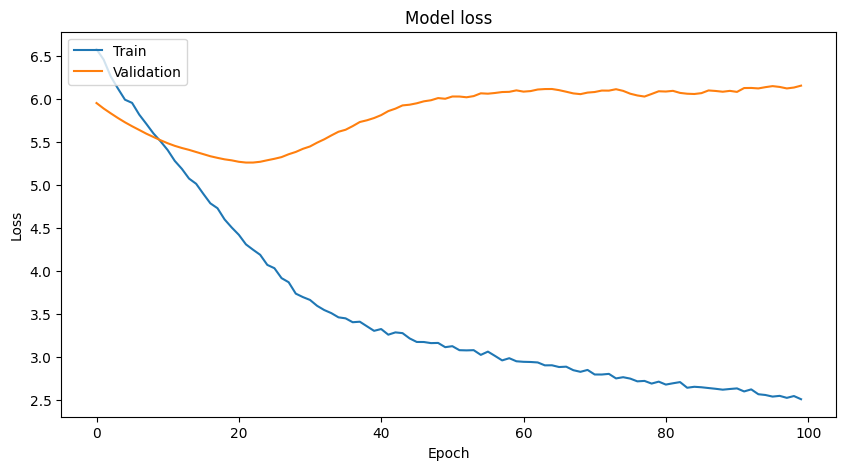

In [235]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Training Loss (Blue Line): The loss on the training set decreases consistently as the number of epochs increases. This indicates that the model is learning from the training data, fitting the training dataset better over time. Validation Loss (Orange Line): The validation loss decreases initially and then plateaus, maintaining a consistent level of loss across epochs. This behavior is typical and suggests that the model has learned to generalize to some extent, as it is not showing signs of overfitting with an increasing validation loss. Gap Between Training and Validation Loss: The gap between the training and validation loss seems relatively stable after the initial epochs. This is a good sign as it implies that the model has not overfit the training data; otherwise, we would see the training loss continuing to decrease while the validation loss started to increase.

For Mkt-RF, the Random Forest model has the highest out-of-sample 𝑅2, indicating the best performance among the models tested.

For SMB, while still negative, the Random Forest again has the least negative out-of-sample 𝑅2, which suggests it's the best (least bad) among the models tested.

For HML, the Neural Network model outperforms the other models with a positive out-of-sample 𝑅2.

For RMW, the Neural Network model has the least negative out-of-sample 𝑅2, making it the relative best among the models for this factor.

For CMA, the Random Forest model provides a small positive out-of-sample 𝑅2, though it's close to the performance of the Neural Network.

Based on these observations, you might consider using a combination of models for different factors. The Random Forest seems to be the most consistently strong performer across multiple factors, with the Neural Network model showing promise particularly for HML and RMW.

## Trading Strategy : Factor Timing

### Calculating Metrics for each Factors

The code below makes predictions for several factors without implementing a trading strategy. This is just to set a benchmark as to what the our predictions are going to look like.

In [236]:
# The code below summarizes Annualized Returns, Annualized StDev, Max Drawdown, and Sharpe Ratio of each factor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd



# Define your predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Split the data into training and testing sets
# For time-series, it's important not to shuffle the dataset
X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factors], test_size=0.2, shuffle=False)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)

# Dictionary to hold predictions
rf_predictions = {}

# Train a model for each factor and make predictions
for factor in factors:
    rf_model.fit(X_train, y_train[factor])
    predictions = rf_model.predict(X_test)
    rf_predictions[factor] = predictions

# Convert predictions to DataFrame
rf_predictions_df = pd.DataFrame(rf_predictions, index=y_test.index)

# Calculate annualized returns and stdev assuming monthly returns
annualized_returns = rf_predictions_df.mean() * 12
annualized_std = rf_predictions_df.std() * np.sqrt(12)

# Function to calculate max drawdown
def max_drawdown(return_series):
    comp_ret = (1 + return_series).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    drawdown = (comp_ret - peak) / peak
    return drawdown.min()

# Calculate max drawdown
max_drawdowns = rf_predictions_df.apply(max_drawdown)

# Risk-free rate for Sharpe Ratio
risk_free_rate = 0.02 / 12  # assuming a 2% annual rate

# Calculate Sharpe Ratio
sharpe_ratios = (annualized_returns - risk_free_rate) / annualized_std

# Output the metrics
metrics = pd.DataFrame({
    'Annualized Returns': annualized_returns,
    'Annualized StDev': annualized_std,
    'Max Drawdown': max_drawdowns,
    'Sharpe Ratio': sharpe_ratios
})

print(metrics)


        Annualized Returns  Annualized StDev  Max Drawdown  Sharpe Ratio
Mkt-RF           17.465492          3.244433     -0.279100      5.382706
SMB              -2.514323          1.372590     -0.999990     -1.833023
HML               2.517185          2.529168     -0.996554      0.994603
RMW              -0.771646          2.005076     -0.999697     -0.385678
CMA              -1.195200          0.976175     -0.993360     -1.226077


## Running Random Forest on each factors separately

#### HML

In [237]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'merged_data' is your DataFrame with predictors and the 'HML' factor
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
X = merged_data[predictors]
y = merged_data['HML']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Generate predictions for the out-of-sample data
predictions = rf_model.predict(X_test)

# Create signals based on predictions and shift them to the next period to simulate real trading
signals = np.where(predictions > 0, 1, -1)
shifted_signals = np.roll(signals, shift=1)
# The first signal can't be used because we don't have a previous prediction for it
shifted_signals[0] = 0

# Calculate strategy returns
strategy_returns = y_test * shifted_signals

# Calculate cumulative returns for the investment strategy
cumulative_returns = (1 + strategy_returns).cumprod() - 1

# Calculate max drawdown
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Calculate other performance metrics
average_monthly_rf_rate = merged_data['RF'].mean()  # Convert the mean RF to decimal if needed
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

# Print the performance metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")

Max Drawdown: -12.3438103037658
Annualized Mean Returns: 4.172307692307692
Annualized Standard Deviation: 10.530496547573698
Sharpe Ratio: 0.3861750836006268


#### Mkt-RF

In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'merged_data' is a DataFrame with your predictors and the Mkt-RF factor returns
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
X = merged_data[predictors]
y = merged_data['Mkt-RF']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Generate predictions
predictions = rf_model.predict(X_test)

# Create signals and shift them for realistic trading
signals = np.where(predictions > 0, 1, -1)
shifted_signals = np.roll(signals, shift=1)
shifted_signals[0] = 0  # First signal cannot be acted upon

# Calculate strategy returns
strategy_returns = y_test * shifted_signals

# Convert the mean RF to decimal and use it directly (ensure it's monthly and convert to decimal if necessary)
average_monthly_rf_rate = merged_data['RF'].mean()  # Assuming it's given in percentage form

# Calculate performance metrics
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

# Calculate cumulative strategy returns and max drawdown
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = np.maximum.accumulate(cumulative_returns)
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Output the performance metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -213.9449491385011
Annualized Mean Returns: 8.146153846153847
Annualized Standard Deviation: 10.962358842175135
Sharpe Ratio: 0.7334608959823251


#### SMB

In [239]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'merged_data' is a DataFrame with your predictors and the SMB factor returns
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
X = merged_data[predictors]
y = merged_data['SMB']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Generate predictions
predictions = rf_model.predict(X_test)

# Create signals and shift them for realistic trading
signals = np.where(predictions > 0, 1, -1)
shifted_signals = np.roll(signals, shift=1)
shifted_signals[0] = 0  # First signal cannot be acted upon

# Calculate strategy returns
strategy_returns = y_test * shifted_signals

# Use the direct average monthly risk-free rate (ensure it's in decimal form)
average_monthly_rf_rate = merged_data['RF'].mean() # Convert from percentage if necessary

# Calculate performance metrics
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

# Calculate cumulative strategy returns and max drawdown
cumulative_returns = (1 + strategy_returns).cumprod() - 1

# Correcting the calculation for max drawdown to avoid division by zero or -inf values
cumulative_returns[cumulative_returns == 0] = -0.0001
rolling_max = np.maximum.accumulate(cumulative_returns)
rolling_max[rolling_max == 0] = np.finfo(float).eps  # smallest positive float
max_drawdown = ((cumulative_returns - rolling_max) / rolling_max).min()

# Output the performance metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -761.5337905117318
Annualized Mean Returns: 4.6523076923076925
Annualized Standard Deviation: 9.429105447414486
Sharpe Ratio: 0.48218947279480184


#### CMA

In [240]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is a DataFrame with your predictors and the CMA factor returns
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
X = merged_data[predictors]
y = merged_data['CMA']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Generate predictions
predictions = rf_model.predict(X_test)

# Create signals and shift them for realistic trading
signals = np.where(predictions > 0, 1, -1)
shifted_signals = np.roll(signals, shift=1)
shifted_signals[0] = 0  # First signal cannot be acted upon

# Calculate strategy returns
strategy_returns = y_test * shifted_signals

# Use the direct average monthly risk-free rate (ensure it's in decimal form)
average_monthly_rf_rate = merged_data['RF'].mean()   # Convert from percentage if necessary

# Calculate performance metrics
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

# Calculate cumulative strategy returns and max drawdown
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = np.maximum.accumulate(cumulative_returns)
max_drawdown = ((cumulative_returns - rolling_max) / rolling_max).min()

# Output the performance metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -4.608685897620486
Annualized Mean Returns: 0.6507692307692309
Annualized Standard Deviation: 6.0111909481719685
Sharpe Ratio: 0.09067702686148803


#### RMW 

In [241]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Assuming 'merged_data' is your DataFrame with predictors and the RMW factor
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
X = merged_data[predictors]
y = merged_data['RMW']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Generate predictions
predictions = rf_model.predict(X_test)

# Create signals and shift them for realistic trading
signals = np.where(predictions > 0, 1, -1)
shifted_signals = np.roll(signals, shift=1)
shifted_signals[0] = 0  # First signal cannot be acted upon

# Align returns with shifted signals
strategy_returns = y_test.shift(-1) * shifted_signals
strategy_returns = strategy_returns.dropna()

# Cumulative returns and max drawdown
cumulative_returns = (1 + strategy_returns).cumprod() - 1
cumulative_returns[cumulative_returns <= 0] = np.finfo(float).eps
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Performance metrics
average_monthly_rf_rate = merged_data['RF'].mean()
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - (average_monthly_rf_rate / 100)) / annualized_std_dev

# Output the performance metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -0.9999999999999998
Annualized Mean Returns: 0.6384
Annualized Standard Deviation: 4.109436944400047
Sharpe Ratio: 0.15509255539048675


## Transaction Costs

The code below calculates transaction costs for each individual model listed above. Each model must be run before executing the code below.

In [242]:
def calculate_strategy_metrics(transaction_cost_bps):
    # Convert basis points to a decimal
    transaction_cost = transaction_cost_bps / 10000
    
    # Calculate strategy returns with transaction cost
    # Assume costs occur every time the position changes (i.e., when the signal changes)
    # Calculate changes in position only for periods where strategy returns are available
    changes_in_position = np.diff(shifted_signals[:len(strategy_returns)], prepend=0) != 0

    net_returns = strategy_returns - changes_in_position * transaction_cost

    # Calculate cumulative returns
    cumulative_returns = (1 + net_returns).cumprod() - 1
    cumulative_returns[cumulative_returns <= 0] = np.finfo(float).eps

    # Max drawdown calculation
    rolling_max = cumulative_returns.cummax()
    drawdowns = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdowns.min()

    # Performance metrics
    annualized_mean_returns = net_returns.mean() * 12
    annualized_std_dev = net_returns.std() * np.sqrt(12)
    sharpe_ratio = (annualized_mean_returns - (average_monthly_rf_rate / 100)) / annualized_std_dev

    # Output the performance metrics
    print(f"Transaction Cost: {transaction_cost_bps} bps")
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Annualized Mean Returns: {annualized_mean_returns}")
    print(f"Annualized Standard Deviation: {annualized_std_dev}")
    print(f"Sharpe Ratio: {sharpe_ratio}\n")

# Test various levels of transaction costs
for cost in [10, 20, 50]:
    calculate_strategy_metrics(cost)


Transaction Cost: 10 bps
Max Drawdown: -0.9999999999999998
Annualized Mean Returns: 0.632160000000001
Annualized Standard Deviation: 4.109752634891789
Sharpe Ratio: 0.1535623024035594

Transaction Cost: 20 bps
Max Drawdown: -0.9999999999999998
Annualized Mean Returns: 0.6259200000000001
Annualized Standard Deviation: 4.110069060247041
Sharpe Ratio: 0.15203225730847422

Transaction Cost: 50 bps
Max Drawdown: -0.9999999999999998
Annualized Mean Returns: 0.6072000000000002
Annualized Standard Deviation: 4.1110227437950275
Sharpe Ratio: 0.14744337715911673



## Exploring Combo Factor Strategies

#### Equal Weights

In [243]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {factor: RandomForestRegressor(random_state=0, n_estimators=100) for factor in factors}

# Train-test split and train models
split_data = {}
for factor in factors:
    X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factor], test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    rf_models[factor].fit(X_train, y_train)

# Generate predictions and signals for the out-of-sample data
factor_predictions = {}
for factor in factors:
    _, X_test, _, y_test = split_data[factor]
    predictions = rf_models[factor].predict(X_test)
    factor_predictions[factor] = predictions

# Create a DataFrame for predictions
predictions_df = pd.DataFrame(factor_predictions, index=X_test.index)

# Generate equal-weighted composite signals from the predictions
composite_signals = np.sign(predictions_df.mean(axis=1))

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(composite_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Align the signals with the out-of-sample data
aligned_signals = pd.Series(shifted_composite_signals, index=predictions_df.index)

# Calculate strategy returns for each factor
strategy_returns_df = pd.DataFrame(index=predictions_df.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns_df[factor] = aligned_signals * y_test

# Portfolio strategy return is the mean return across all factors
portfolio_strategy_returns = strategy_returns_df.mean(axis=1)

# Performance Metrics Calculation
cumulative_returns = (1 + portfolio_strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

average_monthly_rf_rate = merged_data['RF'].mean()  # Assuming RF column for risk-free rate
annualized_mean_returns = portfolio_strategy_returns.mean() * 12
annualized_std_dev = portfolio_strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -3.2454897452558455
Annualized Mean Returns: 1.4335384615384614
Annualized Standard Deviation: 4.769045210683
Sharpe Ratio: 0.27843018784382334


#### Performance Weighted

In [244]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {factor: RandomForestRegressor(random_state=0, n_estimators=100) for factor in factors}

# Split data and train models
split_data = {}
historical_sharpes = {}
for factor in factors:
    X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factor], test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model
    
    # Calculate historical Sharpe ratio using in-sample (training) data
    rf_rate = merged_data['RF'].mean()  # Assuming the risk-free rate is provided in 'merged_data'
    excess_returns = y_train - rf_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)  # Assuming monthly data
    historical_sharpes[factor] = sharpe_ratio if not np.isnan(sharpe_ratio) else 0

# Normalize the Sharpe ratios to get weights
total_sharpe = sum(historical_sharpes.values())
weights = {factor: sharpe / total_sharpe for factor, sharpe in historical_sharpes.items()}

# Predict out-of-sample data and generate weighted signals
weighted_signals = pd.Series(0, index=X_test.index)
for factor, rf_model in rf_models.items():
    _, X_test, _, _ = split_data[factor]
    predictions = rf_model.predict(X_test)
    weighted_signals += predictions * weights[factor]

# Generate signals from the weighted predictions
composite_signals = np.sign(weighted_signals)

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(composite_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += (y_test * shifted_composite_signals) * weights[factor]

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12  # Assuming monthly data
annualized_std_dev = strategy_returns.std() * np.sqrt(12)  # Assuming monthly data
sharpe_ratio = (annualized_mean_returns - rf_rate) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -18.69911248538685
Annualized Mean Returns: 2.5581076725826515
Annualized Standard Deviation: 6.982425826205701
Sharpe Ratio: 0.3512268409191256


#### Confidence Weighting

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {factor: RandomForestRegressor(random_state=0, n_estimators=100) for factor in factors}

# Split data and train models
split_data = {}
confidence_scores = {}
for factor in factors:
    X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factor], test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model
    
    # Generate predictions and calculate confidence scores for the out-of-sample data
    predictions = rf_model.predict(X_test)
    confidence_scores[factor] = np.abs(predictions)  # Using absolute value as a proxy for confidence

# Normalize confidence scores to sum to 1
total_confidence = np.sum([scores for scores in confidence_scores.values()], axis=0)
normalized_confidence = {factor: confidence_scores[factor] / total_confidence for factor in factors}

# Create weighted signals based on model confidence
weighted_signals = pd.Series(0, index=X_test.index)
for factor in factors:
    _, X_test, _, _ = split_data[factor]
    weighted_signals += np.sign(rf_models[factor].predict(X_test)) * normalized_confidence[factor]

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(weighted_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += y_test * shifted_composite_signals

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12  # Assuming monthly data
annualized_std_dev = strategy_returns.std() * np.sqrt(12)  # Assuming monthly data
sharpe_ratio = (annualized_mean_returns - merged_data['RF'].mean()) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -2.934193363684687
Annualized Mean Returns: 10.18324007892646
Annualized Standard Deviation: 16.783630726727097
Sharpe Ratio: 0.6004390787260445


#### Volatility Weighting

In [246]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {factor: RandomForestRegressor(random_state=0, n_estimators=100) for factor in factors}

# Train-test split and train models
split_data = {}
factor_volatility = {}
for factor in factors:
    X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factor], test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model
    
    # Calculate historical volatility using in-sample (training) data
    historical_vol = y_train.rolling(window=12).std().dropna().mean()  # Monthly data, adjust the window as needed
    factor_volatility[factor] = historical_vol if not np.isnan(historical_vol) else 0

# Invert the volatilities to use them as weights (lower volatility gets higher weight)
# Normalize the weights to sum to 1
volatility_weights = {factor: 1.0 / vol if vol != 0 else 0 for factor, vol in factor_volatility.items()}
total_weight = sum(volatility_weights.values())
normalized_weights = {factor: weight / total_weight for factor, weight in volatility_weights.items()}

# Generate weighted signals for the out-of-sample data
weighted_signals = pd.Series(0, index=X_test.index)
for factor in factors:
    _, X_test, _, _ = split_data[factor]
    predictions = rf_models[factor].predict(X_test)
    weighted_signals += np.sign(predictions) * normalized_weights[factor]

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(weighted_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += y_test * shifted_composite_signals

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12  # Assuming monthly data
annualized_std_dev = strategy_returns.std() * np.sqrt(12)  # Assuming monthly data
sharpe_ratio = (annualized_mean_returns - merged_data['RF'].mean()) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -21731.877789500508
Annualized Mean Returns: 20.262480561701466
Annualized Standard Deviation: 12.269079826637428
Sharpe Ratio: 1.6428932355828925


### Volatility Weighting with Stop Loss

In [295]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {factor: RandomForestRegressor(random_state=0, n_estimators=100) for factor in factors}

# Train-test split and train models
split_data = {}
factor_volatility = {}
for factor in factors:
    X_train, X_test, y_train, y_test = train_test_split(merged_data[predictors], merged_data[factor], test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model
    
    # Calculate historical volatility using in-sample (training) data
    historical_vol = y_train.rolling(window=12).std().dropna().mean()  # Monthly data, adjust the window as needed
    factor_volatility[factor] = historical_vol if not np.isnan(historical_vol) else 0

# Invert the volatilities to use them as weights (lower volatility gets higher weight)
# Normalize the weights to sum to 1
volatility_weights = {factor: 1.0 / vol if vol != 0 else 0 for factor, vol in factor_volatility.items()}
total_weight = sum(volatility_weights.values())
normalized_weights = {factor: weight / total_weight for factor, weight in volatility_weights.items()}

# Generate weighted signals for the out-of-sample data
weighted_signals = pd.Series(0, index=X_test.index)
for factor in factors:
    _, X_test, _, _ = split_data[factor]
    predictions = rf_models[factor].predict(X_test)
    weighted_signals += np.sign(predictions) * normalized_weights[factor]

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(weighted_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += y_test * shifted_composite_signals

# Stop-loss 
stop_loss_ratio = 0.1
for i in range(len(strategy_returns)):
    if strategy_returns[i] < -stop_loss_ratio:
        strategy_returns[i] = -stop_loss_ratio

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12  # Assuming monthly data
annualized_std_dev = strategy_returns.std() * np.sqrt(12)  # Assuming monthly data
sharpe_ratio = (annualized_mean_returns - merged_data['RF'].mean()) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -0.19008303681453606
Annualized Mean Returns: 21.715239088987108
Annualized Standard Deviation: 11.952908647779978
Sharpe Ratio: 1.8078902314131176


## Testing Quadratic Costs

In [247]:
def simulate_with_quadratic_costs(strategy_signals, initial_capital, alpha, strategy_returns):
    """
    Simulate strategy performance considering quadratic transaction costs.
    - strategy_signals: trading signals from the Random Forest model.
    - initial_capital: starting capital for the simulation.
    - alpha: coefficient for quadratic transaction costs.
    - strategy_returns: actual returns based on RF model predictions.
    """
    # Initialize the array for positions and net returns
    positions = np.zeros(len(strategy_signals))
    positions[0] = initial_capital  # Start with the initial capital

    net_returns = np.zeros_like(positions)
    net_returns[0] = strategy_returns.iloc[0]

    # Calculate positions and apply transaction costs
    for i in range(1, len(strategy_signals)):
        # Predicted change in position based on the signal
        new_position = positions[i-1] * (1 + strategy_returns.iloc[i])

        # Volume traded is based on the absolute change
        volume_traded = np.abs(new_position - positions[i-1])

        # Calculate quadratic transaction costs
        transaction_costs = alpha * volume_traded ** 2

        # Update positions considering transaction costs
        positions[i] = positions[i-1] + (new_position - positions[i-1]) - transaction_costs

        # Calculate net returns after transaction costs
        net_returns[i] = (positions[i] - positions[i-1]) / positions[i-1] if positions[i-1] != 0 else 0

    # Calculate cumulative returns
    cumulative_returns = (1 + pd.Series(net_returns)).cumprod() - 1

    return cumulative_returns

In [249]:
def generate_signals_and_returns(rf_models, split_data):
    """Generate trading signals and returns from Random Forest model predictions."""
    strategy_signals = pd.DataFrame(index=split_data[list(factors)[0]][1].index)  # Assuming all factors have the same test set index
    strategy_returns = pd.DataFrame(index=strategy_signals.index)

    for factor, model_data in rf_models.items():
        X_test = split_data[factor][1]
        predictions = model_data.predict(X_test)
        
        # Generate signals (buy if prediction is positive, sell if negative)
        signals = np.sign(predictions)
        
        # Calculate returns (assuming returns are proportional to the magnitude of predictions for simplicity)
        returns = predictions / 100  # Example: Scale down predictions to simulate realistic returns

        strategy_signals[factor] = signals
        strategy_returns[factor] = returns

    # Aggregate signals and returns (average across factors)
    strategy_signals['combined'] = strategy_signals.mean(axis=1)
    strategy_returns['combined'] = strategy_returns.mean(axis=1)

    return strategy_signals['combined'], strategy_returns['combined']

# Generate signals and returns
strategy_signals, strategy_returns = generate_signals_and_returns(rf_models, split_data)


In [250]:
capitals = [100000, 500000, 1000000, 5000000]
alphas = [1e-6, 5e-6, 1e-5]
for capital in capitals:
    print(f"Initial Capital: {capital}")
    for alpha in alphas:
        cumulative_returns = simulate_with_quadratic_costs(strategy_signals, capital, alpha, strategy_returns)
        print(f"  Alpha {alpha}: Final Cumulative Return: {cumulative_returns.iloc[-1]}")
    print()

Initial Capital: 100000
  Alpha 1e-06: Final Cumulative Return: 0.06922872594825491
  Alpha 5e-06: Final Cumulative Return: 0.06910086946827687
  Alpha 1e-05: Final Cumulative Return: 0.0689410859034143

Initial Capital: 500000
  Alpha 1e-06: Final Cumulative Return: 0.06910086946827709
  Alpha 5e-06: Final Cumulative Return: 0.06846198196956088
  Alpha 1e-05: Final Cumulative Return: 0.06766429707492749

Initial Capital: 1000000
  Alpha 1e-06: Final Cumulative Return: 0.06894108590341386
  Alpha 5e-06: Final Cumulative Return: 0.06766429707492749
  Alpha 1e-05: Final Cumulative Return: 0.0660720019762322

Initial Capital: 5000000
  Alpha 1e-06: Final Cumulative Return: 0.06766429707492727
  Alpha 5e-06: Final Cumulative Return: 0.061319584078664224
  Alpha 1e-05: Final Cumulative Return: 0.05347958716652457



## Predictions using lookahead method (PythonPractice8)

### Mkt-RF

In [251]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is already loaded with your data
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factor = 'Mkt-RF'  # Example factor

# Preparing the data
merged_data['lookahead_returns'] = merged_data[factor].shift(-1)  # Create lookahead returns

X = merged_data[predictors].dropna()
y = merged_data['lookahead_returns'].dropna()

# Ensure alignment of X and y after shifting and dropping NA
X = X.loc[y.index]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predict lookahead returns
predicted_lookahead_returns = rf_model.predict(X_test)

# Define thresholds for confidence in predicted returns
upper_threshold = 0.02  # 2% upward movement
lower_threshold = -0.02  # 2% downward movement

# Generate signals based on dynamic thresholds
signals = np.where(predicted_lookahead_returns > upper_threshold, 1,
                   np.where(predicted_lookahead_returns < lower_threshold, -1, 0))

shifted_signals = np.roll(signals, shift=1)
shifted_signals[0] = 0  # Adjust the first signal

# Check for indices within the dataset
future_index = X_test.index + pd.DateOffset(months=1)
future_index = future_index[future_index.isin(merged_data.index)]  # Check if future_index exists in the data

if len(future_index) > 0:
    actual_future_returns = merged_data.loc[future_index, factor]

    # Ensure the length of signals and actual future returns match
    if len(shifted_signals) > len(actual_future_returns):
        shifted_signals = shifted_signals[:len(actual_future_returns)]

    # Calculate strategy returns
    strategy_returns = actual_future_returns.reset_index(drop=True) * pd.Series(shifted_signals).reset_index(drop=True)

    # Calculate performance metrics
    cumulative_returns = (1 + strategy_returns).cumprod() - 1
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).min()
    annualized_mean_returns = strategy_returns.mean() * 12
    annualized_std_dev = strategy_returns.std() * np.sqrt(12)
    average_monthly_rf_rate = merged_data['RF'].mean()
    sharpe_ratio = (annualized_mean_returns - average_monthly_rf_rate) / annualized_std_dev

    # Output the performance metrics
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Annualized Mean Returns: {annualized_mean_returns}")
    print(f"Annualized Standard Deviation: {annualized_std_dev}")
    print(f"Sharpe Ratio: {sharpe_ratio}")
else:
    print("No data available for the calculated future index.")


Max Drawdown: 0.0
Annualized Mean Returns: 6.831428571428571
Annualized Standard Deviation: 9.629027885616388
Sharpe Ratio: 0.6984854902936783


### Volatility-based weighting

In [252]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {}

# Initialize data structures
split_data = {}
factor_volatility = {}

# Adding lookahead returns for each factor to the dataset
for factor in factors:
    merged_data[factor + '_lookahead'] = merged_data[factor].shift(-1)

for factor in factors:
    # Prepare the dataset for this factor
    y = merged_data[factor + '_lookahead'].dropna()  # Target variable
    X = merged_data[predictors].loc[y.index]  # Aligning predictors with the target

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)

    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model

    # Calculate historical volatility using in-sample (training) data
    historical_vol = y_train.rolling(window=12).std().dropna().mean()
    factor_volatility[factor] = historical_vol if not np.isnan(historical_vol) else 0

# Volatility-based weighting
volatility_weights = {f: 1.0 / vol if vol != 0 else 0 for f, vol in factor_volatility.items()}
total_weight = sum(volatility_weights.values())
normalized_weights = {f: weight / total_weight for f, weight in volatility_weights.items()}

# Generate weighted signals for the out-of-sample data
weighted_signals = pd.Series(0, index=X_test.index)
for factor, model in rf_models.items():
    _, X_test, _, _ = split_data[factor]
    predictions = model.predict(X_test)
    weighted_signals += np.sign(predictions) * normalized_weights[factor]

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(weighted_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += y_test * shifted_composite_signals

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - merged_data['RF'].mean()) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -27.96621305346532
Annualized Mean Returns: 12.859969395406022
Annualized Standard Deviation: 9.751329665586944
Sharpe Ratio: 1.3079526100655134


### Performance Weight

In [253]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'merged_data' is your DataFrame with all predictors and factors
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Initialize Random Forest models for each factor
rf_models = {}

# Train-test split and train models, calculate lookahead returns
split_data = {}
historical_sharpes = {}
for factor in factors:
    # Adding lookahead returns for each factor to the dataset
    merged_data[factor + '_lookahead'] = merged_data[factor].shift(-1)
    
    # Prepare the dataset for this factor
    y = merged_data[factor + '_lookahead'].dropna()  # Use lookahead returns as the target
    X = merged_data[predictors].loc[y.index]  # Align predictors with the target
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    split_data[factor] = (X_train, X_test, y_train, y_test)
    
    # Train Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)
    rf_models[factor] = rf_model
    
    # Calculate historical Sharpe ratio using in-sample (training) lookahead data
    rf_rate = merged_data['RF'].mean()  # Assuming the risk-free rate is provided in 'merged_data'
    excess_returns = (y_train - rf_rate) / y_train.std()
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)
    historical_sharpes[factor] = sharpe_ratio if not np.isnan(sharpe_ratio) else 0

# Normalize the Sharpe ratios to get weights
total_sharpe = sum(historical_sharpes.values())
weights = {factor: sharpe / total_sharpe for factor, sharpe in historical_sharpes.items()}

# Predict out-of-sample data and generate weighted signals
weighted_signals = pd.Series(0, index=X_test.index)
for factor, model in rf_models.items():
    _, X_test, _, _ = split_data[factor]
    predictions = model.predict(X_test)
    weighted_signals += np.sign(predictions) * weights[factor]

# Shift signals to avoid lookahead bias
shifted_composite_signals = np.roll(weighted_signals, shift=1)
shifted_composite_signals[0] = 0  # First signal is unusable

# Apply the strategy
strategy_returns = pd.Series(0, index=y_test.index)
for factor in factors:
    _, _, _, y_test = split_data[factor]
    strategy_returns += y_test * shifted_composite_signals

# Calculate performance metrics
cumulative_returns = (1 + strategy_returns).cumprod() - 1
rolling_max = cumulative_returns.cummax()
drawdowns = (cumulative_returns - rolling_max) / rolling_max
max_drawdown = drawdowns.min()
annualized_mean_returns = strategy_returns.mean() * 12
annualized_std_dev = strategy_returns.std() * np.sqrt(12)
sharpe_ratio = (annualized_mean_returns - rf_rate) / annualized_std_dev

# Output the metrics
print(f"Max Drawdown: {max_drawdown}")
print(f"Annualized Mean Returns: {annualized_mean_returns}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Max Drawdown: -7.955776432671923
Annualized Mean Returns: 0.977188290073734
Annualized Standard Deviation: 15.32608583806793
Sharpe Ratio: 0.0568635717944857


### Timing with Optimal Weights (EXERCISE 4)

In [254]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

# Assuming merged_data is your DataFrame with factors and predictors

# Define the factors and predictors
factors = ['Mkt-RF', 'HML', 'SMB', 'RMW', 'CMA']
predictors = ['Inflation', 'InterestRate', 'UNRATE', 'CCI', 'VIX', 'D12', 'E12', 'svar']
gamma = 3  # Risk aversion parameter, modify as needed

# Compute excess returns for each factor
for factor in factors:
    merged_data[factor + '_excess'] = merged_data[factor] - merged_data['RF']

# Define a function to perform Random Forest regression and backtesting
def random_forest_timing(data, factor, predictors, gamma):
    # Prepare the data, align features and target
    X = data[predictors].dropna()
    y = data[factor + '_excess'].dropna()
    X = X.loc[y.index]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train the Random Forest model
    rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
    rf_model.fit(X_train, y_train)

    # Predict lookahead returns
    predicted_lookahead_returns = rf_model.predict(X_test)

    # Compute optimal weights (w*) using the mean-variance utility function
    mu_pred = predicted_lookahead_returns.mean()
    var_pred = predicted_lookahead_returns.var()
    w_star = mu_pred / (gamma * var_pred)

    # Align the signals with the actual future returns
    future_returns = y_test.shift(-1).dropna()  # Shift the actual returns for lookahead
    signals = pd.Series(np.where(predicted_lookahead_returns[:-1] > 0, 1, -1), index=future_returns.index)

    # Calculate weighted strategy returns based on the signals and future returns
    strategy_returns = w_star * signals * future_returns

    # Calculate performance metrics
    cumulative_returns = (1 + strategy_returns).cumprod()
    max_drawdown = (cumulative_returns.cummax() - cumulative_returns).min()
    annualized_return = strategy_returns.mean() * 12
    annualized_std = strategy_returns.std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - merged_data['RF'].mean()) / annualized_std

    # Output the performance metrics
    print(f"Strategy for factor {factor}:")
    print(f"Max Drawdown: {max_drawdown}")
    print(f"Annualized Return: {annualized_return}")
    print(f"Sharpe Ratio: {sharpe_ratio}")

# Perform the Random Forest timing for each factor
for factor in factors:
    random_forest_timing(merged_data, factor, predictors, gamma)


Strategy for factor Mkt-RF:
Max Drawdown: 0.0
Annualized Return: 4.28416837685976
Sharpe Ratio: 0.6343104102527062
Strategy for factor HML:
Max Drawdown: 0.0
Annualized Return: -0.03575047115545191
Sharpe Ratio: -1.8227987916049775
Strategy for factor SMB:
Max Drawdown: 0.0
Annualized Return: 1.8350572057293522
Sharpe Ratio: 0.1492554045550133
Strategy for factor RMW:
Max Drawdown: 0.0
Annualized Return: 0.3439392991921937
Sharpe Ratio: 0.6350338699597978
Strategy for factor CMA:
Max Drawdown: 0.0
Annualized Return: -5.326521409330862
Sharpe Ratio: -1.4534181587096007
